<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_1_GIACOMO_CARFI_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

# Loading the dataset

https://github.com/Andrew-Wyn/ISPR_HWS/blob/master/MidTerm3_1/ISPR_HW3.ipynb

In [1]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%%capture
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchview import draw_graph

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [3]:
def split_data_and_label(dataset):
  X = dataset.data.float()
  y = dataset.targets
  return X,y

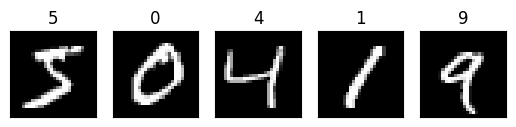

In [4]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

X_train, y_train = split_data_and_label(train_data)
X_test, y_test = split_data_and_label(test_data)

plot_example(X_train, y_train)

# Preparing the dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# resize the dataset - flatten
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

# scaling the dataset
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))
X_test = torch.Tensor(minmaxscaler.transform(X_test))
print("Max:", torch.max(X_train).item())
print("Min:", torch.min(X_train).item())

Max: 1.0
Min: 0.0


The implementation chosen for this assignment is a **denoising autoencoder**, so below a method for adding noise to images is implemented

In [6]:
# add noise to the images
def add_noise(X, mean=0, std=1):
  noisy_imgs = X + torch.randn(X.shape)*std + mean 
  # Clip the images to be between 0 and 1
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  return noisy_imgs

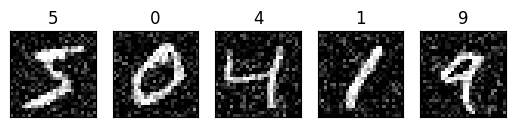

In [7]:
noise_std = 0.2
X_train_noisy = add_noise(X_train[:5], 0, noise_std)
plot_example(X_train_noisy, y_train)

# Utils

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def evaluate_MSE(model, eval_dataset):
  with torch.no_grad():
    eval_output = model(eval_dataset)

    loss = F.mse_loss(eval_output, eval_dataset)
  
  return loss.item()

In [10]:
def fit(epochs, model, X_train):
  
  print(X_train.shape)
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(X_train, batch_size=20, shuffle=True)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  history = []

  for epoch in range(1, epochs+1):
    model.train()

    for images in train_loader:
      # reset gradient
      optimizer.zero_grad()

      # add noise
      noisy_images = add_noise(images, 0, noise_std)

      #forward pass
      output = model(noisy_images)
      loss = criterion(output, images)

      # optimizer step and backward pass
      loss.backward()
      optimizer.step()

    train_loss = evaluate_MSE(model, X_train)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
    history.append(train_loss)
    
  return history

In [11]:
def evaluate(model, data):
  criterion = nn.MSELoss()
  X_test_noisy = add_noise(data, 0, noise_std)
  with torch.no_grad():
    output = model(X_test_noisy)
    loss = criterion(output, data) 

  return loss, X_test_noisy, output

In [12]:
def check_results(input, denoised, original, label):
  # show images and their reconstruction
  rows = 3
  columns = 5

  fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 10))
  for i in range(rows):
      for j in range(columns):
          if i==0:
            axes[i, j].imshow(input[j].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(label[j].item(), fontsize=20) 
          if i==1:
            axes[i, j].imshow(denoised[j].reshape(28, 28), cmap='gray')
          if i==2:
            axes[i, j].imshow(original[j].reshape(28, 28), cmap='gray')

          axes[i, j].tick_params(left = False, right = False , labelleft = False,
                  labelbottom = False, bottom = False)
          
  axes[0, 0].set_ylabel("INPUT", fontsize=20)        
  axes[1, 0].set_ylabel("DENOISED", fontsize=20)
  axes[2, 0].set_ylabel("ORIGINAL", fontsize=20)
  
  plt.show()

In [13]:
# counting the number of free params of the model
def count_parameters(model):
    free_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {free_params} free params")

# Autoencoder definition

In [14]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, enc_dim, last_layer=True):
    super(Autoencoder, self).__init__()
    self.last_layer = last_layer
    self.input_dim = input_dim
    self.enc_dim = enc_dim
    # encoder made of one linear layer that maps a vector of size input dim into a vector of size enc_dim
    self.encoder = nn.Linear(input_dim, enc_dim)
    # the decoder will reconstruct the image in the original space
    self.decoder = nn.Linear(enc_dim, input_dim)

    self.enc_activation = nn.ReLU()

    if self.last_layer:
      self.dec_act = nn.Sigmoid()
    else:
      self.dec_act = nn.ReLU()
   
  def encode(self, x):
    x = self.encoder(x)
    x = self.enc_activation(x)
    return x
  
  def decode(self, x):
    x = self.decoder(x)
    x = self.dec_act(x)
    return x

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

In [15]:
epochs=10

# Single Layer Autoencoder

In [30]:
model = Autoencoder(X_train.shape[1], 128)
count_parameters(model)

The model has 201616 free params


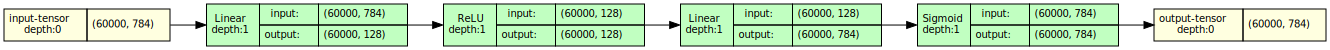

In [31]:
model_graph = draw_graph(model, input_size=X_train.shape, expand_nested=True, graph_dir='LR')
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [32]:
history = fit(epochs, model, X_train)

torch.Size([60000, 784])
Epoch: 1 	Training Loss: 0.047197286039590836
Epoch: 2 	Training Loss: 0.03586342930793762
Epoch: 3 	Training Loss: 0.023581523448228836
Epoch: 4 	Training Loss: 0.014379291795194149
Epoch: 5 	Training Loss: 0.0106322867795825
Epoch: 6 	Training Loss: 0.00812233705073595
Epoch: 7 	Training Loss: 0.0072470917366445065
Epoch: 8 	Training Loss: 0.0070949094370007515
Epoch: 9 	Training Loss: 0.006607620511204004
Epoch: 10 	Training Loss: 0.006486981641501188


In [19]:
loss, noisy_data, denoised = evaluate(model, X_test)
print("Single layer AutoEncoder loss:", loss.item())

Single layer AutoEncoder loss: 0.005014795809984207


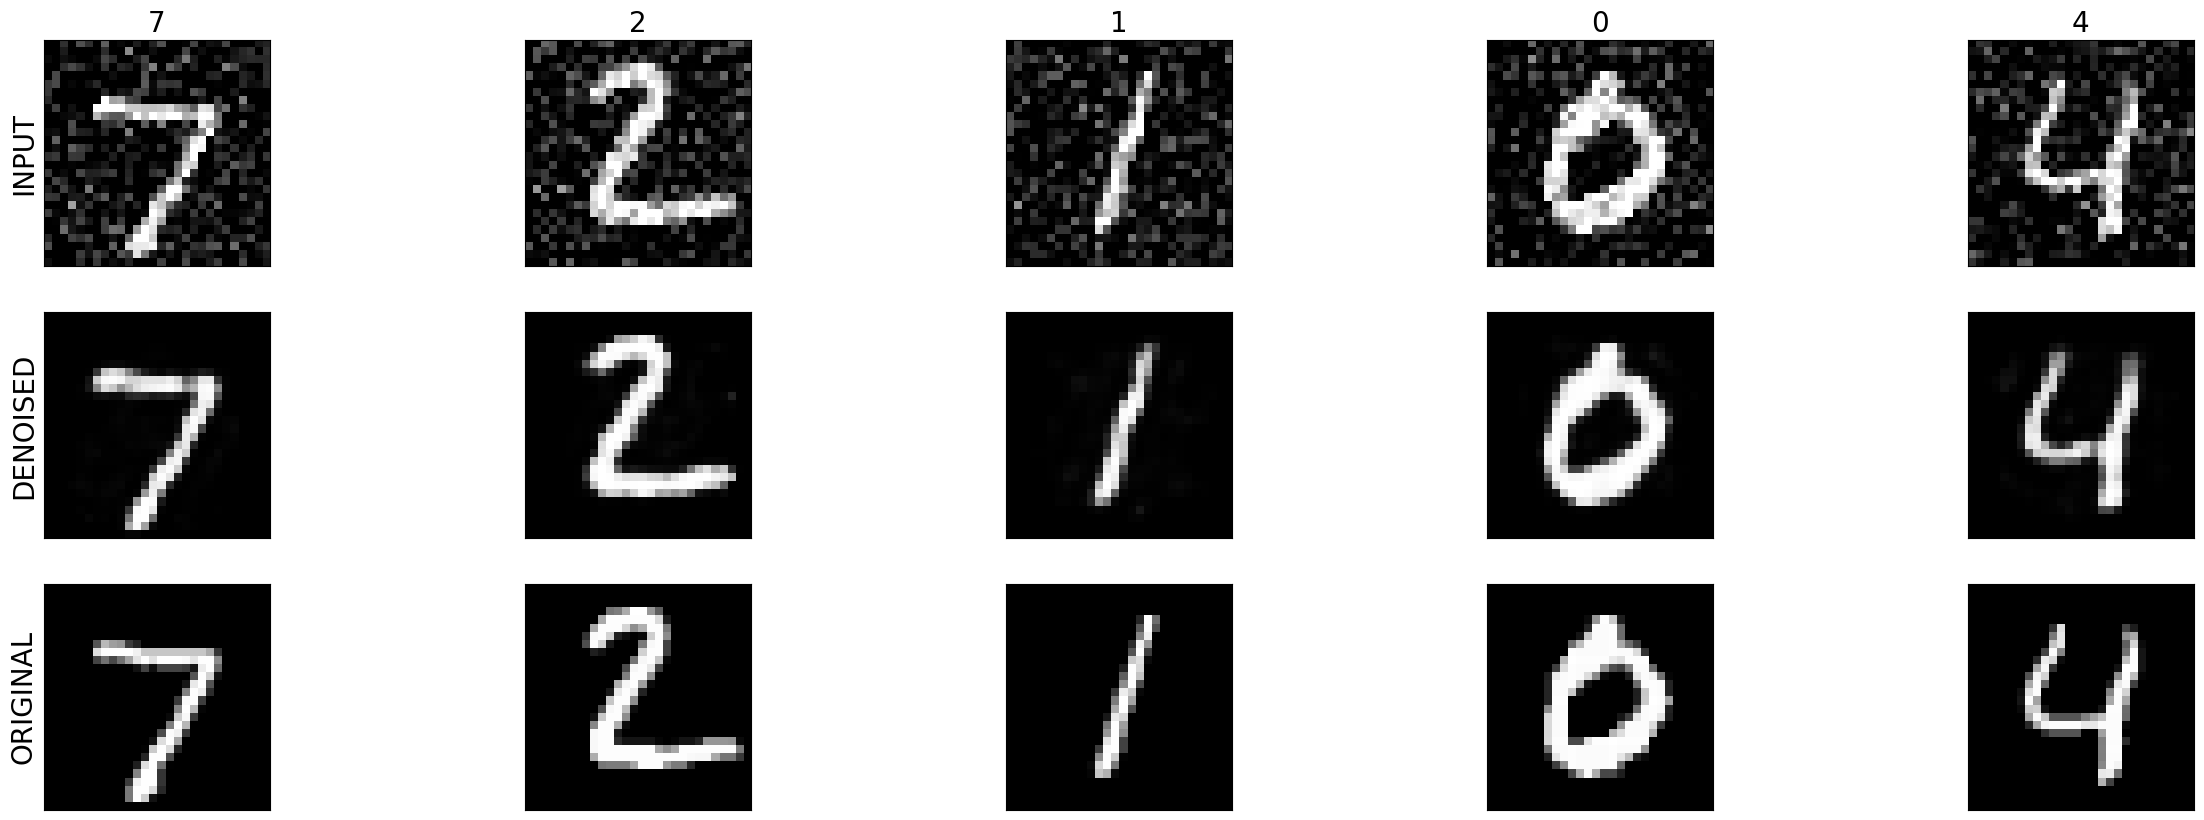

In [20]:
check_results(noisy_data, denoised, X_test, y_test)

# Deep AutoEncoder with only layerwise pretraining

In [21]:
class DeepAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_layers):
    super().__init__()

    # first layer, the decoder will reconstruct the image
    self.autoencoders = [Autoencoder(input_dim, hidden_layers[0])]
    print(f"Adding autoencoder with dim {input_dim} {hidden_layers[0]}")
    input_dim = hidden_layers[0]
    hidden_layers.pop(0)

    for elem in hidden_layers:
      print(f"Adding autoencoder with dim {input_dim} {elem}")
      self.autoencoders.append(Autoencoder(input_dim, elem, False))
      input_dim = elem
      
    self.model = nn.ModuleList(self.autoencoders)
  
  def encode(self, x):
    enc = x
    for ae in self.model:
      enc = ae.encode(enc)
    return enc

  def decode(self, x):
    dec = x
    # reverse list of models and decode
    for ae in self.model[::-1]:
      dec = ae.decode(dec)
    return dec

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x



In [22]:
hidden_layers = [512, 256, 128]
deep_ae = DeepAutoEncoder(X_train.shape[1], hidden_layers)
count_parameters(deep_ae)

Adding autoencoder with dim 784 512
Adding autoencoder with dim 512 256
Adding autoencoder with dim 256 128
The model has 1132944 free params


In [23]:
#model_graph = draw_graph(deep_ae, input_size=X_train.shape, expand_nested=True, graph_dir='LR')
#model_graph.resize_graph(scale=10)
#model_graph.visual_graph

In [24]:
data_in = X_train
for ae in deep_ae.model:
  fit(2, ae, data_in)
  # create latent rappresentation of data
  # the new encoded data_in will be passed to the data loader in the fit method
  with torch.no_grad():
    data_in = ae.encode(data_in)


torch.Size([60000, 784])
Epoch: 1 	Training Loss: 0.02601216547191143
Epoch: 2 	Training Loss: 0.009953733533620834
torch.Size([60000, 512])
Epoch: 1 	Training Loss: 3.080594062805176
Epoch: 2 	Training Loss: 3.150391101837158
torch.Size([60000, 256])
Epoch: 1 	Training Loss: 238.51806640625
Epoch: 2 	Training Loss: 293.49652099609375


# Deep AutoEncoder with Fine Tuning

In [27]:
history = fit(2, deep_ae, X_train)

torch.Size([60000, 784])
Epoch: 1 	Training Loss: 0.009268602356314659
Epoch: 2 	Training Loss: 0.008387407287955284


In [28]:
loss, noisy_data, denoised = evaluate(deep_ae, X_test)
print("Deep AutoEncoder loss:", loss.item())

Deep AutoEncoder loss: 0.008082248270511627


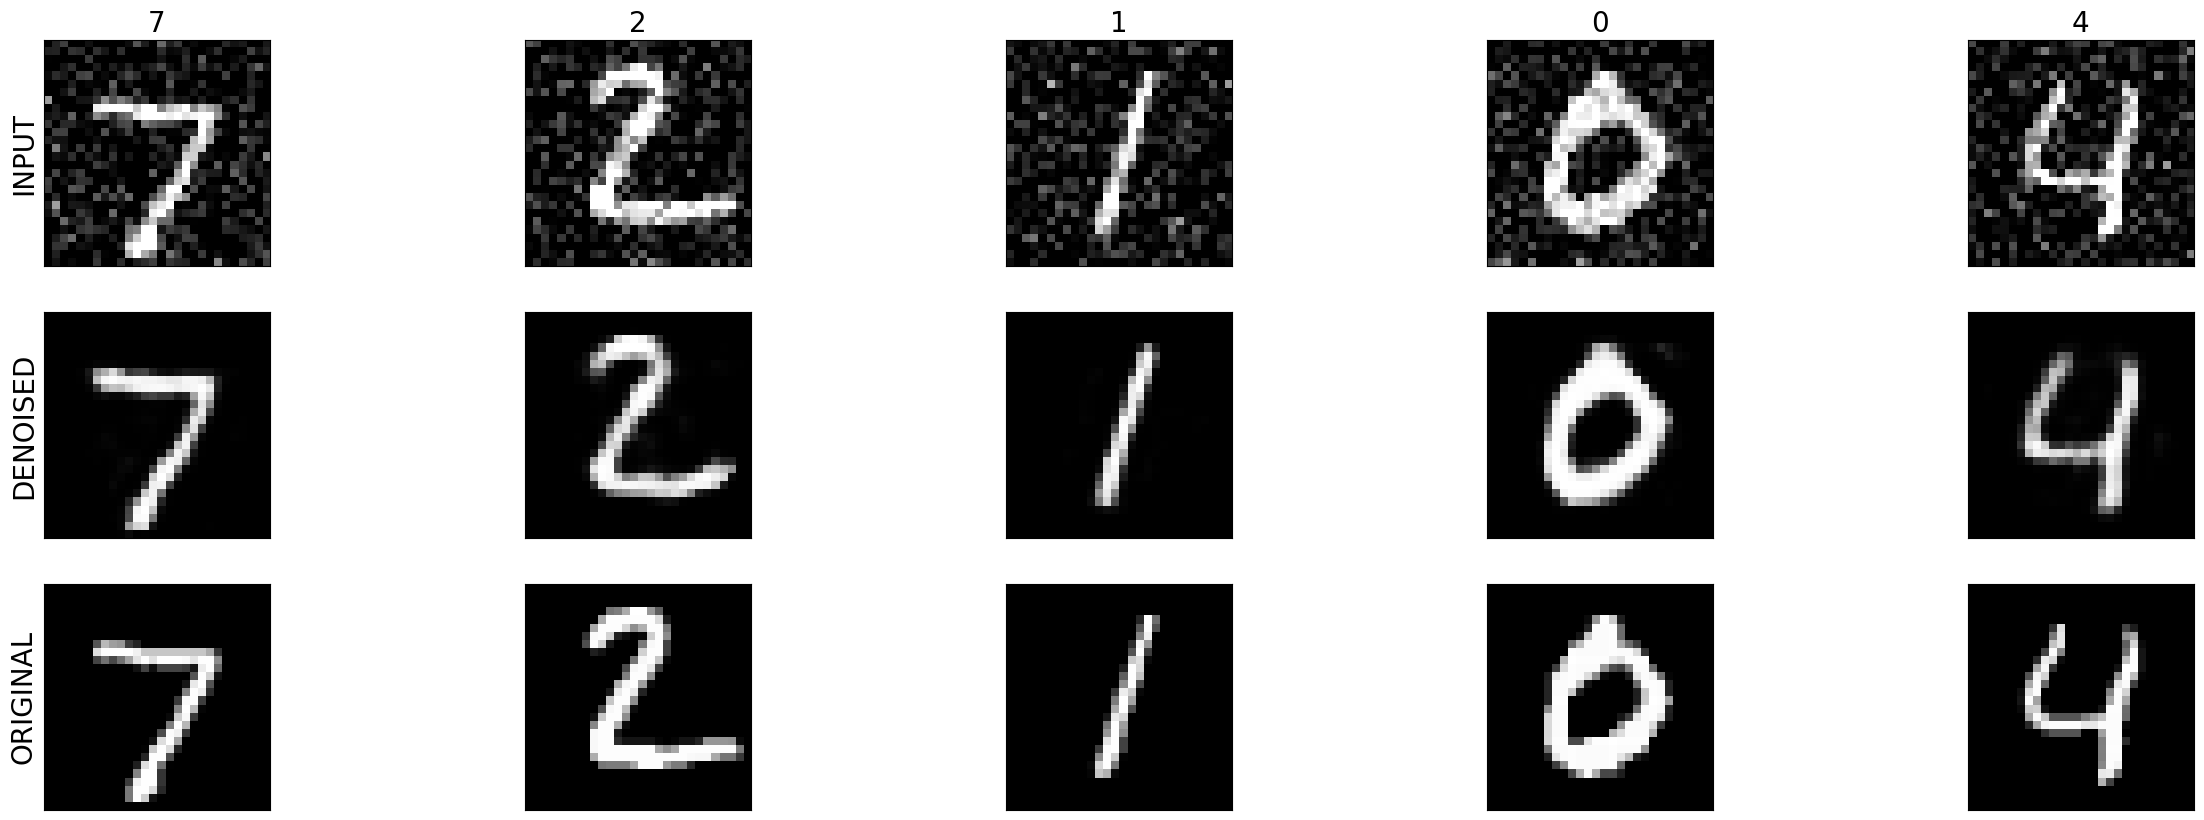

In [29]:
check_results(noisy_data, denoised, X_test, y_test)

# Latent Space Interpolation

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

In [81]:
def plot_interpolations(X, alphas):
    """Plot 5 images in a row."""
    for i, img in enumerate(X):
        img = img.reshape((28, 28))
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"alpha: {alphas[1]}")

In [82]:
def compute_interpolation(model, img1, img2):
  with torch.no_grad():
    encoding1 = model.encode(img1)
    encoding2 = model.encode(img2)

    # trying different values of alphas
    values = 5
    alphas = []
    interpolated_images = []
    for i in range(values):
      alpha = i/5
      alphas.append(alpha)
      interpolation = alpha *encoding1 + (1 - alpha)*encoding2
    
      #compute decoding starting from the interpolation
      result = model.decode(interpolation)
      interpolated_images.append(result)

    plot_interpolations(interpolated_images, alphas)

## Interpolation using images of the same class

In [83]:
# choose two images of the class 5

# Find indices of all examples with label 5
idx_5 = (y_test == 5)

# Filter X_test to get examples with label 5
X_test_5 = X_test[idx_5]
X_test_5.shape

torch.Size([892, 784])

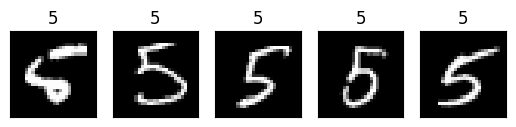

In [84]:
plot_example(X_test_5, y_test[idx_5])

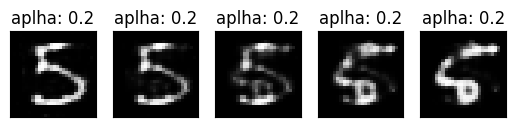

In [85]:
# select the first two images
img1 = X_test_5[0]
img2 = X_test_5[1]

# to show the result of a latent space interpolation 
# I choose as models the single layer autoencoder trained before
# compute latent space rapresentation for two different images
compute_interpolation(model, img1, img2)

## Interpolation using images of different classes

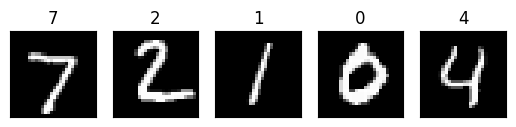

In [59]:
plot_example(X_test, y_test)

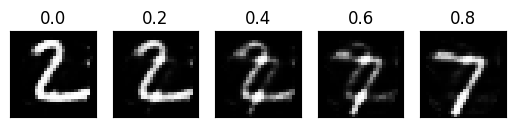

In [73]:
# select the first two images 
img1 = X_test[0]
img2 = X_test[1]

# to show the result of a latent space interpolation 
# I choose as models the single layer autoencoder trained before
# compute latent space rapresentation for two different images
compute_interpolation(model, img1, img2)